In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# base_model = ResNet50(weights='imagenet', include_top=False)


In [2]:
model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    # Dense(117,activation='softmax')
    Dense(27,activation='softmax')
])

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledStates\train'
validation_data_dir = r'..\Data\labledStates\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [5]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical')


Found 19117 images belonging to 27 classes.
Found 2565 images belonging to 27 classes.


In [6]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.01

# class_probabilities = class_counts
class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


PiauA: 0.027544104579720407
Mato Grosso: 0.028702118374706282
Pernambuco: 0.02873664440706391
Bahia: 0.028945566580042322
SAPSo Paulo: 0.02915756450987691
Santa Catarina: 0.029264738223942034
Rio de Janeiro: 0.029336628377010013
Rio Grande do Norte: 0.02940887439979804
MaranhAPSo: 0.029738457160869633
Minas Gerais: 0.029738457160869633
EspArito Santo: 0.029812708615200405
ParanA!: 0.029887333668844624
ParA!: 0.029924787179152437
Mato Grosso do Sul: 0.03034309017364576
CearA!: 0.030537138565777878
GoiA!s: 0.030615458192508518
Rio Grande do Sul: 0.030615458192508518
Tocantins: 0.030615458192508518
ParaAba: 0.03184065730873721
Roraima: 0.03235878893756392
Sergipe: 0.03471347310207269
RondA'nia: 0.0436126090724608
Acre: 0.04442718332453974
Amazonas: 0.04900642993939244
Alagoas: 0.051115385143782756
Distrito Federal: 0.0634106469326399
AmapA!: 0.11659023968476476


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    # steps_per_epoch=2000,
    validation_data=validation_generator,
    # validation_steps=200,
    batch_size=64,
    epochs=3,
    # class_weight = class_weights,
    # verbose=1
    callbacks=[early_stopping]
)

Epoch 1/3


598/598 [==============================] - 494s 820ms/step - loss: 3.1002 - categorical_accuracy: 0.0981 - val_loss: 2.8935 - val_categorical_accuracy: 0.1712
Epoch 2/3
598/598 [==============================] - 225s 375ms/step - loss: 2.4572 - categorical_accuracy: 0.2814 - val_loss: 3.2109 - val_categorical_accuracy: 0.1497
Epoch 3/3
598/598 [==============================] - 277s 463ms/step - loss: 1.5469 - categorical_accuracy: 0.5395 - val_loss: 3.9555 - val_categorical_accuracy: 0.1821


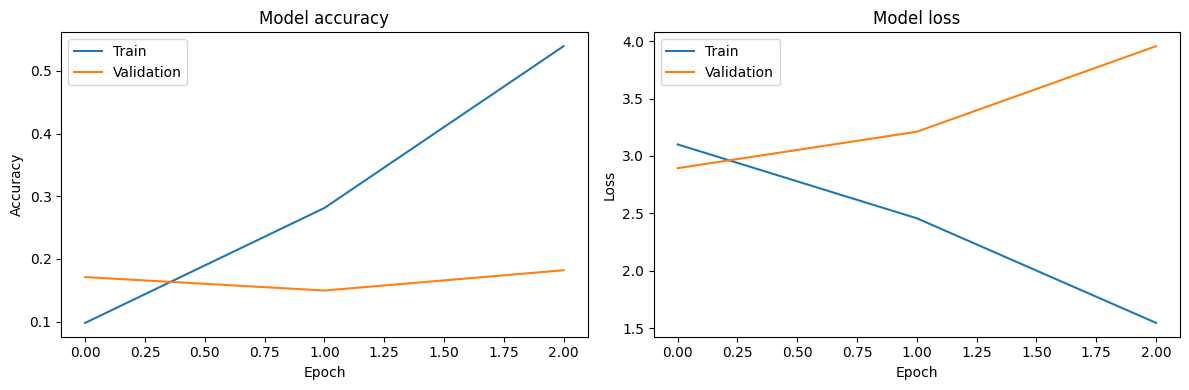

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
model.save('my_model.h5')


c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledStates\test'
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

class_names = train_generator.class_indices.keys()
print(len(class_names))

Found 2450 images belonging to 27 classes.
27


77/77 [==============================] - 45s 581ms/step
Classification Report: 
                     precision    recall  f1-score   support

               Acre       0.00      0.00      0.00        50
            Alagoas       0.00      0.00      0.00        80
             AmapA!       0.00      0.00      0.00        30
           Amazonas       0.47      0.18      0.26       110
              Bahia       0.03      0.08      0.04        77
             CearA!       0.13      0.11      0.12       108
   Distrito Federal       0.00      0.00      0.00        30
     EspArito Santo       0.42      0.29      0.34       102
             GoiA!s       0.03      0.02      0.02       125
         MaranhAPSo       0.15      0.17      0.16        93
        Mato Grosso       0.35      0.42      0.38        85
 Mato Grosso do Sul       0.25      0.27      0.26       109
       Minas Gerais       0.09      0.19      0.12       100
              ParA!       0.12      0.21      0.15        94
    

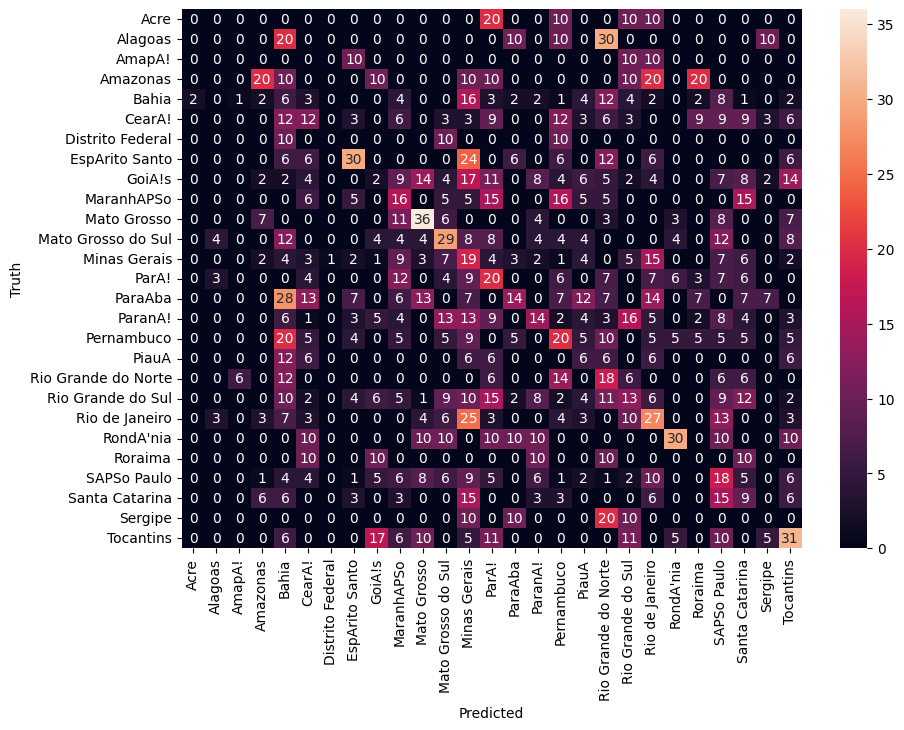

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes

# Predict the values from the validation dataset
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# classification report
print('Classification Report: ')
print(classification_report(y_true, y_pred_classes, target_names=class_names))


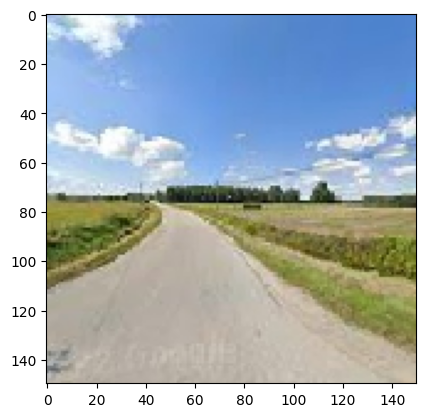

1/1 [==============================] - 0s 225ms/step
Country: ['Alagoas'], Probability: 0.2439146190881729
Country: ['Sergipe'], Probability: 0.2197607457637787
Country: ['Pernambuco'], Probability: 0.13028311729431152
Country: ['Rio Grande do Sul'], Probability: 0.08631839603185654
Country: ['ParanA!'], Probability: 0.06543897092342377
Country: ['ParA!'], Probability: 0.0602567233145237
Country: ['MaranhAPSo'], Probability: 0.03737851604819298
Country: ['SAPSo Paulo'], Probability: 0.0308685302734375
Country: ['GoiA!s'], Probability: 0.029458394274115562
Country: ['Roraima'], Probability: 0.021393820643424988
Country: ['Bahia'], Probability: 0.017874721437692642
Country: ['Distrito Federal'], Probability: 0.010852839797735214
Country: ['CearA!'], Probability: 0.00982823595404625
Country: ['ParaAba'], Probability: 0.007840589620172977
Country: ['Santa Catarina'], Probability: 0.007651800289750099
Country: ['Minas Gerais'], Probability: 0.0074711753986775875
Country: ['Tocantins'], Prob

In [12]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Poland\_t3q0ct2UHEnJ0t3jR2SkQNum0.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [13]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
